# [Face Detection with a Sliding Window](https://www.cc.gatech.edu/~hays/compvision/proj5/)
1. Extract features for positive examples
2. Extract features for random negative examples
3. Mine hard negatives
4. Train a linear classifier
5. Detect faces on the test set

## Setup

In [1]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
from utils import *
import student_code as sc

In [2]:
data_path = osp.join('..','data')
# Positive training examples. 36x36 head crops
train_path_pos = osp.join(data_path, 'caltech_faces', 'Caltech_CropFaces')
# Mine random or hard negatives from here
non_face_scn_path = osp.join(data_path, 'train_non_face_scenes')
# CMU+MIT test scenes
test_scn_path = osp.join(data_path, 'test_scenes', 'test_jpg')
# Ground truth face locations in the test set
label_filename = osp.join(data_path, 'test_scenes', 'ground_truth_bboxes.txt')

# The faces are 36x36 pixels, which works fine as a template size. You could
# add other fields to this dict if you want to modify HoG default
# parameters such as the number of orientations, but that does not help
# performance in our limited test.
feature_params = {'template_size': 36, 'hog_cell_size': 6}

# Number of negatives to use for training.
# Higher will work strictly better, but you should start with 10000 for debugging
num_negative_examples = 10000

## Section 1: Load positive training crops and random negative examples

In [3]:
features_pos = sc.get_positive_features(train_path_pos, feature_params)

Number of face crops: 6713
Finished extracting positive HoG features. Shape: (6713, 1116)


In [4]:
features_neg = sc.get_random_negative_features(non_face_scn_path, feature_params,
                                               num_negative_examples)

using a step size of: 15
Using multiple scales for negative feature extraction. Scales are: [0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25]
Finished extracting negative HoG features. Shape: (10000, 1116)
Time taken: 63.8212616443634


## Section 2: Train Classifier
Use [scikit-learn LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) to on your training features to learn a linear classifier. The regularization constant C is an important parameter, try many values. Small values seem to work better (e.g. 1e-4), but you can try other values.

In [5]:
c_val = 5e-2
# c_val = 5e-3
conf_thres = -0.5
svm = sc.train_classifier(features_pos, features_neg, c_val)

Training linear SVM with positive samples weights of: 1.0


## Section 3: Examine Learned Classifier
You don't need to modify anything in this section. The section first
evaluates _training_ error, which isn't ultimately what we care about,
but it's a good sanity check. Your training error should be very low.

In [6]:
confidences = svm.decision_function(np.vstack((features_pos, features_neg)))
label_vector = np.hstack((np.ones(len(features_pos)), -np.ones(len(features_neg))))
[tp_rate, fp_rate, tn_rate, fn_rate] = report_accuracy(confidences, label_vector)

Accuracy = 99.725%
True Positive rate = 99.494%
False Positive rate = 0.120%
True Negative rate = 99.880%
False Negative rate = 0.506%


Visualize how well separated the positive and negative examples are at
training time. Sometimes this can idenfity odd biases in your training
data, especially if you're trying hard negative mining. This
visualization won't be very meaningful with the placeholder starter code.

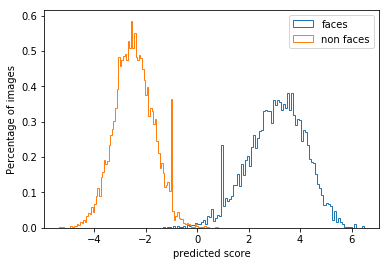

In [7]:
face_confs = confidences[label_vector > 0]
non_face_confs = confidences[label_vector < 0]
plt.figure()
plt.hist(np.sort(face_confs), 100, facecolor='g', histtype='step', density=1,label='faces')
plt.hist(np.sort(non_face_confs), 100, facecolor='r', histtype='step',density=1, label='non faces')
#plt.plot([0, len(non_face_confs)], [0, 0], 'b', label='decision boundary')
plt.xlabel('predicted score')
plt.ylabel('Percentage of images')
plt.legend()

Visualize the HOG feature template to examine if the detector has learned a meaningful representation for the object (faces in this case).  This would be a good thing to include in your writeup.

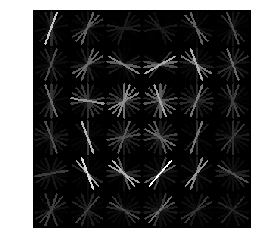

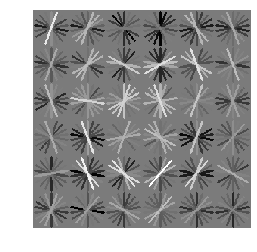

In [8]:
visualize_hog(svm, feature_params)

## Section 4: Mine Hard Negatives
You can get very good performance by using random negatives, so hard negative mining may not show great improvement for face detection. Hard negative mining would probably be more important if you had a strict budget of negative training examples or a
more expressive, non-linear classifier that can benefit from more training data.

In [9]:
hard_negs = sc.mine_hard_negs(non_face_scn_path, svm, feature_params, conf_thres)
features_neg_2 = np.vstack((features_neg, hard_negs))

Mining for hard negs using a step size of: 15 and confidence threshold of: -0.5
Using multiple scales for negative feature extraction. Scales are: [0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25]
(3961, 1116)
Time taken: 68.19071769714355


Then you can train the classifier again with the new features_neg. You can also check the difference of the performance.

In [10]:
svm_2 = sc.train_classifier(features_pos, features_neg_2, c_val)

Training linear SVM with positive samples weights of: 1.0


## Section 5: Run Detector on Test Set
Make sure the outputs of sc.run_detector() are properly structured! They will be interpreted in Section 6 to evaluate and visualize your
results. See sc.run_detector() documentation for more details.

sc.run_detector() will have (at least) two parameters which can heavily
influence performance - how much to rescale each step of your multiscale
detector, and the threshold for a detection. If your recall rate is low
and your detector still has high precision at its highest recall point,
you can improve your average precision by reducing the threshold for a
positive detection.

In [ ]:
bboxes, confidences, image_ids = sc.run_detector(test_scn_path, svm, feature_params, False, conf_thres)

Detecting faces at multiple scales of: [0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25] 

Running detector with step size of: 15 and confidence threshold of: -0.5 

Detecting faces in ../data/test_scenes/test_jpg/Argentina.jpg
NMS done, 9 detections passed
Detecting faces in ../data/test_scenes/test_jpg/Arsenal.jpg
NMS done, 11 detections passed
Detecting faces in ../data/test_scenes/test_jpg/Brazil.jpg
NMS done, 11 detections passed
Detecting faces in ../data/test_scenes/test_jpg/Colombia.jpg
NMS done, 11 detections passed
Detecting faces in ../data/test_scenes/test_jpg/Ecuador.jpg
NMS done, 11 detections passed
Detecting faces in ../data/test_scenes/test_jpg/England.jpg
NMS done, 11 detections passed
Detecting faces in ../data/test_scenes/test_jpg/Germany.jpg
NMS done, 10 detections passed
Detecting faces in ../data/test_scenes/test_jpg/J-L_Picard.Baldy.jpg
NMS done, 5 detections passed
Detecting faces in ../data/test_scenes/test_jpg/USA.jpg
NMS done, 13 detections passed

Let's detect again using the classifier trained using hard negative examples. The results will be saved separately.

In [ ]:
bboxes_2, confidences_2, image_ids_2 = sc.run_detector(test_scn_path, svm_2, feature_params, False, conf_thres)

## Section 6: Evaluate and Visualize Detections
These functions require ground truth annotations, and thus can only be run on the CMU+MIT face test set. 
Don't modify anything in evaluate_detections()!

Performance to aim for:
- random (stater code): 0.001 AP
- single scale: ~ 0.3 to 0.4 AP
- multiscale: ~ 0.75 to 0.9 AP

You need to implement multi-scale detection and achieve at least 0.8 AP to receive the full credit.

First we compare the detection performance between different classifiers quantitatively.

In [ ]:
gt_ids, gt_bboxes, gt_isclaimed, tp, fp, duplicate_detections = evaluate_detections(bboxes, confidences,
                                                                                    image_ids, label_filename)

In [ ]:
gt_ids, gt_bboxes, gt_isclaimed, tp_2, fp_2, duplicate_detections_2 = evaluate_detections(bboxes_2, confidences_2,
                                                                                    image_ids_2, label_filename)

And then we show the detection results on the test scenes. By default we only show the results from the second classifier. You can also check the first classifier by uncommenting the first line.

In [ ]:
# visualize_detections_by_image(bboxes, confidences, image_ids, tp, fp, test_scn_path, label_filename)
visualize_detections_by_image(bboxes_2, confidences_2, image_ids_2, tp_2, fp_2, test_scn_path, label_filename)

## (Optional) Visualize Detections on Extra Scenes
Uncomment the following codes to test your detector on extra scenes. 

In [ ]:
# test_scn_path_extra = osp.join(data_path, 'extra_test_scenes') # Bonus scenes
# bboxes_extra, confidences_extra, image_ids_extra = sc.run_detector(test_scn_path_extra, svm_2, feature_params)

In [ ]:
# visualize_detections_by_image_no_gt(bboxes_extra, confidences_extra, image_ids_extra, test_scn_path_extra)